In [1]:
import pandas as pd

import datetime 
import time 

import numpy as np 
import math
import pickle
import os

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams 

from sklearn.cluster import MiniBatchKMeans
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
# convert time to unix timestamp to make it comparable
# and easier to calculate durations
def convert_to_epoch_time(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
    
def clean_data(ddf):
    # ddf -> ddf_ares -> ddf_speed -> ddf_passenger -> ddf_duration
    initial = ddf.shape[0]
    
    # remove outliers in pickup and dropoff locations outside of New York City
    # boundaries of NYC: [latitude] && [longitude] - [40.5774 <= lat <= 40.9176] && [-74.15 <= lon <= -73.7004]
    ddf_area = ddf[((ddf['dropoff_longitude'] >= -74.15) & (ddf['dropoff_longitude'] <= -73.7004) &\
                       (ddf['dropoff_latitude'] >= 40.5774) & (ddf['dropoff_latitude'] <= 40.9176)) & \
                       ((ddf['pickup_longitude'] >= -74.15) & (ddf['pickup_latitude'] >= 40.5774)& \
                       (ddf['pickup_longitude'] <= -73.7004) & (ddf['pickup_latitude'] <= 40.9176))]
    
    
    # remove data points with an unrealistic speed, i. e. speeds <= 0 or speeds > 50 miles per hour
    ddf_speed = ddf_area[(ddf_area['speed'] > 0) & (ddf_area['speed'] <= 50)]
    
    # remove data points with an unrealistic number of passengers, i. e. < 1 or > 6
    ddf_passenger = ddf_speed[(ddf['passenger_count'] >= 1) & (ddf['passenger_count'] <= 6)]
    
    # remove data points with unrealistic trip durations, i. e. t < 1 or t > 720 minutes
    ddf_duration = ddf_passenger[(ddf_passenger['trip_duration'] > 1) & (ddf_passenger['trip_duration'] < 720)]
    
    # remove data points with unrealistic trip lengths, i. e. x <= 0 or x > 25 miles
    ddf_trips = ddf_duration[(ddf_duration['trip_distance'] > 0) & (ddf_duration['trip_distance'] < 25)]
    
    # remove data points with unrealistic fares, i. e. fare <= 0 or fare > 1000 dollars
    ddf_fares = ddf_trips[(ddf_trips['total_amount'] > 0) & (ddf_trips['total_amount'] < 1000)]
    final = ddf_fares.shape[0]
    
    print ("Number of outliers removed: ", (initial - final))
    
    return ddf_fares

def expand_data(ddf):
    # calculate trip durations from the pick-up and drop-off times as well as
    # the trip speed in [mi/h]
    
    # events = ddf[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    events = ddf[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
    
    time_of_pickup = [convert_to_epoch_time(x) for x in events['tpep_pickup_datetime'].values]
    time_of_dropoff = [convert_to_epoch_time(x) for x in events['tpep_dropoff_datetime'].values]
    
    trip_duration = (np.array(time_of_dropoff) - np.array(time_of_pickup)) / float(60)

    # expanded_ddf = ddf[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    expanded_ddf = ddf[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']]
    
    expanded_ddf['trip_duration'] = trip_duration
    expanded_ddf['tof_pickup'] = time_of_pickup
    expanded_ddf['speed'] = 60 * (expanded_ddf['trip_distance'] / expanded_ddf['trip_duration'])
    
    return expanded_ddf


In [3]:
original_df_2016 = pd.read_csv(r'./../data/yellow_tripdata_2016-03.csv')
original_df_2015 = pd.read_csv(r'./../data/yellow_tripdata_2015-03.csv')

In [4]:
def get_kmeans(ddf, n_clusters = 30):
    coords = ddf[['pickup_longitude','pickup_latitude']].values
    kmeans = MiniBatchKMeans(n_clusters = n_clusters, batch_size = 10000,random_state = 33).fit(coords)
    return kmeans

# 2015
# 2015-03-01 00:00:00 ==> 1425168000
# 2015-04-01 00:00:00 ==> 1427846400

# 2016
# 2016-03-01 00:00:00 ==> 1456790400
# 2016-04-01 00:00:00 ==> 1459468800 = 1456790400 + (31 * 24 * 60 * 60)

def bin_data(ddf, kmeans, temp = 900, offset = 1456790400):
    # put data in bins in respect to the location and the time (quarters of an hour passed since March 1st)
    ddf['cluster'] = kmeans.predict(ddf[['pickup_longitude','pickup_latitude']])
    
    pickup_times = [i for i in ddf['tof_pickup'].values]
    binned_tof_pickup = [(int((i - offset) / 900) + 33) for i in pickup_times]
    ddf['temp_bin'] = np.array(binned_tof_pickup)
    
    return ddf

def group_binned_data(ddf):
    grouped_ddf = ddf[['cluster','temp_bin','passenger_count']].groupby(['cluster','temp_bin']).count()
    new_columns = ['cluster','temp_bin','rides']
    grouped_ddf = grouped_ddf.rename(columns=dict(zip(grouped_ddf.columns, new_columns)))
    return grouped_ddf

def fill_up_missing_values(ddf, n_clusters = 30, average = False):
    n_bins = 2976 # = (60 * 60 * 24 * 31) / (900) 
    replacement = 0
    
    for i in range(0, n_clusters):
        cluster_i = ddf[ddf['cluster'] == i]
        try:
            available_bins = list(set(cluster_i['temp_bin']))
        except:
            continue
        if average:
            replacement = cluster_i['rides'].avg()
        
        missing_bins = []
        for k in range(0, n_bins):
            if k not in available_bins:
                missing_bins.append(k)
        
        cluster_index = np.array([i for k in missing_bins])
        bin_index = np.array([k for k in missing_bins])
        replace = np.array([[replacement for k in missing_bins]])
        
        ddf = ddf.append(pd.DataFrame())
        {'cluster': cluster_index, 'temp_bin': bin_index, 'rides': replace}
        ddf = ddf * 1.0
    return ddf

In [5]:
# run this notebook using a number close to 18 Mio. or no brackets at all
# this will take a while
ddf_2016 = original_df_2016[:2000000]
ddf_2015 = original_df_2015[:2000000]

In [6]:
ddf_2015 = expand_data(ddf_2015)
ddf_2016 = expand_data(ddf_2016)

In [7]:
ddf_2015 = clean_data(ddf_2015)
ddf_2016 = clean_data(ddf_2016)

Number of outliers removed:  64809
Number of outliers removed:  55520


In [8]:
kmeans = get_kmeans(ddf_2016)
ddf_2016 = bin_data(ddf_2016, kmeans)
ddf_2015 = bin_data(ddf_2015, kmeans, offset = 1425168000)

As can be seen below each data point gets assigned a time bin (a time frame of 15 minutes) and a location cluster. Plotting any of these data points using the cluster as the color determining value will output the clusters (hotspots) as a set of points. 

In [9]:
ddf_2016.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,tof_pickup,speed,cluster,temp_bin
0,1,2.50,-73.976746,40.765152,-74.004265,40.746128,12.35,7.916667,1.456787e+09,18.947368,3,29
1,1,2.90,-73.983482,40.767925,-74.005943,40.733166,15.35,11.100000,1.456787e+09,15.675676,28,29
2,2,19.98,-73.782021,40.644810,-73.974541,40.675770,63.80,31.100000,1.456787e+09,38.546624,2,29
7,1,6.20,-73.788773,40.647758,-73.829208,40.712345,21.80,16.050000,1.456787e+09,23.177570,2,30
8,1,0.70,-73.958221,40.764641,-73.967896,40.762901,8.80,4.983333,1.456787e+09,8.428094,15,30


The data point in row one belongs to cluster number 16. The center (location) of that cluster/hotspot can be found using the centers of the KMeans clusters. 

In [10]:
cluster_center_row_one = kmeans.cluster_centers_[16]
cluster_center_row_one # <-- plot this as center of the circle or use the data points or both

array([-73.95362513,  40.66775512])

In [11]:
ddf_2015 = group_binned_data(ddf_2015)
ddf_2016 = group_binned_data(ddf_2016)

In [12]:
def calculate_data(ddf, ddf_year_ago, n_cluster = 30, n_bins = 2976):
    # consider data from one week ago -> offset of 672 = 7 * 24 * 60 / 15
    data_collector = []
    label_collector = []
    for i in range(0, n_cluster):
        for k in range(672, n_bins):
            try:
                label = ddf['cluster'][i, k]                      # now
                data_1 = ddf['cluster'][i, k - 1]                 # 15 min ago
                data_2 = ddf['cluster'][i, k - 2]                 # 30 min ago
                data_3 = ddf['cluster'][i, k - 672]               # one week ago
                data_4 = ddf_year_ago['cluster'][i, k]           # one year ago
                data_5 = ddf_year_ago['cluster'][i, k - 1]       # one year and 15 min ago
                data_6 = ddf_year_ago['cluster'][i, k - 2]       # one year and 30 min ago
                data = [data_1, data_2, data_3, data_4, data_5, data_6]
                # data = [data_1, data_2, data_3]
                data_collector.append(np.array(data, dtype = float))
                label_collector.append(label * 1.0)
            except:
                pass
    return data_collector, label_collector

def get_specific_data(ddf, ddf_year_ago, index_cluster, index_bin):
    # consider data from one week ago -> offset of 672 = 7 * 24 * 60 / 15
    # index of bin must be > 672
    
    # if not all data points are used, some pairings of 2015 and 2016 data might not exist
    # as the points are not ordered
    
    if index_bin < 672:
        raise Exception
    
    i = index_cluster
    k = index_bin
    
    try:
        label = ddf['cluster'][i, k]                      # now
        data_1 = ddf['cluster'][i, k - 1]                 # 15 min ago
        data_2 = ddf['cluster'][i, k - 2]                 # 30 min ago
        data_3 = ddf['cluster'][i, k - 672]               # one week ago
        data_4 = ddf_year_ago['cluster'][i, k]           # one year ago
        data_5 = ddf_year_ago['cluster'][i, k - 1]       # one year and 15 min ago
        data_6 = ddf_year_ago['cluster'][i, k - 2]       # one year and 30 min ago
        data = [data_1, data_2, data_3, data_4, data_5, data_6]
        
        return np.array(data, dtype = float), label * 1.0
    except:
        print('Not available')
    return

In [13]:
X, y = calculate_data(ddf_2016, ddf_2015)

The data consists of time points one year ago, a week ago and minutes ago to predict the amount of rides needed during any intervall of 15 minutes (one time bin) at any location.
For visualization purposes assume that the customer can choose a time in March 2016.

In [14]:
print(len(X))
print(len(y))

X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

1054
1054


In [15]:
from sklearn.model_selection import GridSearchCV

# tuned_parameters = [{'n_estimators': [ 5, 10,20,30,50,100],'max_depth':[5,10,20,30]}]
# modelsxgb = GridSearchCV( xgb.XGBRegressor(), tuned_parameters)
# modelsxgb.fit(X_df[:1000], y_df[:1000])
# print(modelsxgb.best_estimator_)

In [16]:
x_model = xgb.XGBRegressor(
 learning_rate =0.300000012,
 n_estimators=20,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 reg_alpha=0, reg_lambda=1,
 colsample_bytree=1)
train = int(X_df.shape[0] * 0.8)
x_model.fit(X_df[:train], y_df[:train])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
actual = y_df[train: train + 100]
predicted = x_model.predict(X_df[train:train + 100])

The model works ideally if all the data points are on the diagonal. As can be seen below the points are scattered around the diagonal which means the model is (somewhat) accurate.

<IPython.core.display.Javascript object>


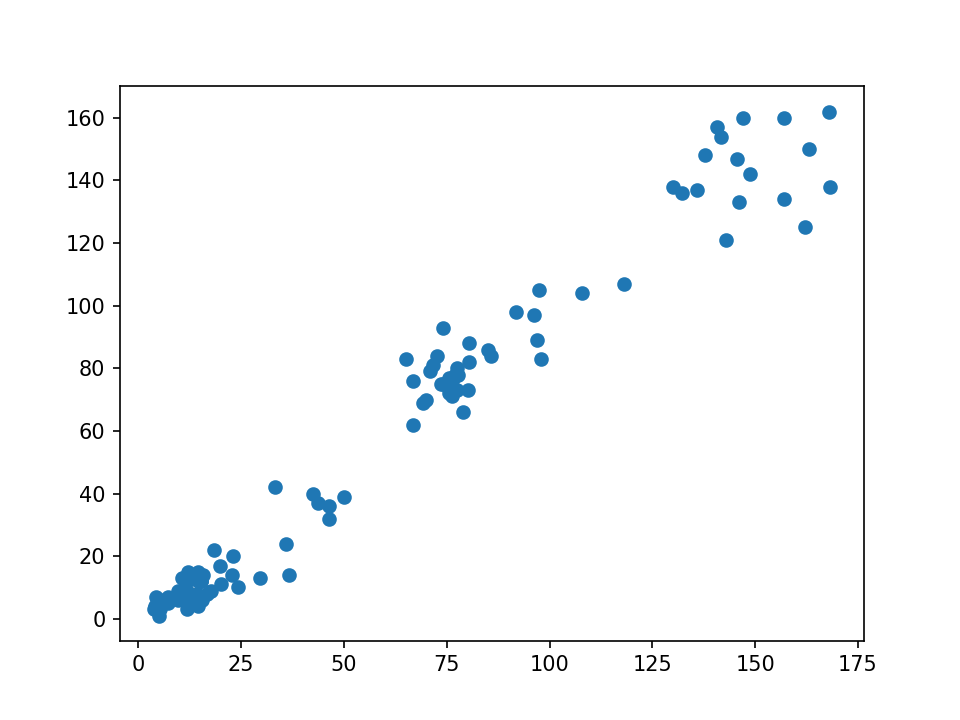

In [18]:
plt.scatter(predicted, actual)
plt.show()

In [21]:
import math

def msq_error(y_test, pred):
    sum = 0
    for val, pre in zip(y_test, pred):
        sum += math.pow((pre - y_test[0]), 2)
    sum /= y_test.shape[0]
    return sum
        
error = msq_error(np.array(actual), predicted)
print("msq_error: %.2f" % (error))

msq_error: 9133.55


In [ ]:
pickle.dump(x_model, open("xgboost.pickle.dat", "wb"))
# loaded_model = pickle.load(open("pima.pickle.dat", "rb"))